### Import
***

In [1]:
from typing import List, Tuple
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open("assets/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

# Number of unique characters
vocab = len(itos)

### Generate Dataset
***

In [4]:
block_size = 3 # context length: Number of characters we take to predict the next one?
X, Y = [], []
for w in words[:3]:
  
    print(w)
    # Initial context for every new word is zero vector of 'block_size'
    context = [0] * block_size
    for ch in w + ".":
        # Index of the character (e.g. A=0, B=1)
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "-->", itos[ix])
        
        # ignore the first letter of current context and add the latest letter
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .


In [5]:
print(X.shape)
print(Y.shape)
X

torch.Size([16, 3])
torch.Size([16])


tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1]])

In [6]:
def build_dataset(words: List[str], block_size: int) -> Tuple[torch.tensor, torch.tensor]:  
    """
    Take list of words to construct tensors X, y where each X observation
    is of length 'blocksize'.
    
    :param words: List of raw inputs.
    :param block_size: Number of characters to use as context for next character.
    :return: Tensors for X (n, 'block_size') and Y (n, )
    """
    X, Y = [], []
    for w in words:

      context = [0] * block_size
      for ch in w + ".":
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [7]:
block_size = 3

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

train_words = words[:n1]
valid_words = words[n1:n2]
test_words = words[n2:]

X_train, Y_train = build_dataset(train_words, block_size=3)
X_valid, Y_valid = build_dataset(valid_words, block_size=3)
X_test, Y_test = build_dataset(test_words, block_size=3)

print("Train:", X_train.shape, Y_train.shape)
print("Valid:", X_valid.shape, Y_valid.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: torch.Size([182625, 3]) torch.Size([182625])
Valid: torch.Size([22655, 3]) torch.Size([22655])
Test: torch.Size([22866, 3]) torch.Size([22866])


### Multi-Layer Perceptron (OHE Input)
***

In [8]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32

# Randomly draw indizes from X_train that go into minibatch
idx = torch.randint(low=0, high=n1, size=(batch_size,))

# Get mini-batch
X_mini = X_train[idx]
Y_mini = Y_train[idx]

# We one-hot-encode our n observations. 
# Each observation holds 3 characters with each 27 length.
input_layer = F.one_hot(X_mini, num_classes=vocab).float() # (n, 3, vocab)

# We want to embedd each character vector from 27 to 2 dimensions
# This means that each observation of 3 characters results in an embedded vector of length 6
C = torch.randn((81, 6), generator=g) # (vocab * block_size, block_size * emb_dimension)

# We need to stack the 3 one-hot-encoded characters togehter (n, 3 * vocab)
# Now dimensions are aligned for matrix
embedd_layer = input_layer.view(-1, 81) @ C # (n, 6)

W1 = torch.randn((6, 100), generator=g) # (block_size * emb_dimension, hidden neurons)
b1 = torch.randn(100, generator=g) # (1 bias term per hidden neuron)

# We have a hidden layer with 100 neurons
hidden_layer = torch.tanh(embedd_layer @ W1 + b1) # (n, 100)

# The output layer should match the number of characters
W2 = torch.randn((100, vocab), generator=g)
b2 = torch.randn(vocab, generator=g)

output_layer = hidden_layer @ W2 + b2 # (n, vocab)

# OPTION 1:
# Convert logits of output layer into probabilities
# Calculate loss as average negative log likelihood
probs = F.softmax(output_layer, dim=1)
loss = -probs[torch.arange(batch_size), Y_mini].log().mean()

# OPTION 2:
# The cross entroy function is equivalent to option 1
# However it is more numerically stable
loss = F.cross_entropy(output_layer, Y_mini)
loss

tensor(20.1390)

### Multi-Layer Perceptron (Embedding Table)
***

In [9]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32

# Randomly draw indizes from X_train that go into minibatch
idx = torch.randint(low=0, high=n1, size=(batch_size,))

# Get mini-batch
X_mini = X_train[idx]
Y_mini = Y_train[idx]

# We one-hot-encode our n observations. 
# Each observation holds 3 characters with each 27 length.
input_layer = F.one_hot(X_mini, num_classes=vocab).float() # (n, 3, vocab)

# We want to embedd each character vector from 27 to 2 dimensions
C = torch.randn((27, 2), generator=g) # (vocab, embedd_length)

# We simply extract the mapping of X from the embedding table C
embedd_layer = C[X_mini]

W1 = torch.randn((6, 100), generator=g) # (block_size * emb_dimension, hidden neurons)
b1 = torch.randn(100, generator=g) # (1 bias term per hidden neuron)

# We have a hidden layer with 100 neurons
hidden_layer = torch.tanh(embedd_layer.view(-1, 6) @ W1 + b1)

# The output layer should match the number of characters
W2 = torch.randn((100, vocab), generator=g)
b2 = torch.randn(vocab, generator=g)

output_layer = hidden_layer @ W2 + b2 # (n, vocab)

# OPTION 1:
# Convert logits of output layer into probabilities
# Calculate loss as average negative log likelihood
probs = F.softmax(output_layer, dim=1)
loss = -probs[torch.arange(batch_size), Y_mini].log().mean()

# OPTION 2:
# The cross entroy function is equivalent to option 1
# However it is more numerically stable
loss = F.cross_entropy(output_layer, Y_mini)
loss

tensor(19.8468)

### Optimization
***

In [14]:
C = torch.randn((81, 6), generator=g) # (vocab * block_size, block_size * emb_dimension)
W1 = torch.randn((6, 100), generator=g) # (block_size * emb_dimension, hidden neurons)
b1 = torch.randn(100, generator=g) # (1 bias term per hidden neuron)
W2 = torch.randn((100, 27), generator=g) # (hidden neurons, output size)
b2 = torch.randn(27, generator=g) # (1 bias term per output)
parameters = [C, W1, b1, W2, b2]

# Add gradient attribute to all tensors
for p in parameters:
    p.requires_grad = True

In [15]:
n_params = sum([p.nelement() for p in parameters])
n_params

3913

In [16]:
# Record loss after each iteration
loss_i = []

In [17]:
batch_size = 32
learn_rate = 0.01

for i in range(50000):

    idx = torch.randint(low=0, high=n1, size=(batch_size,))

    X_mini = X_train[idx]
    Y_mini = Y_train[idx]

    # Forward pass
    input_layer = F.one_hot(X_mini, num_classes=vocab).float()
    embedd_layer = input_layer.view(-1, 81) @ C
    hidden_layer = torch.tanh(embedd_layer @ W1 + b1)
    output_layer = hidden_layer @ W2 + b2
    loss = F.cross_entropy(output_layer, Y_mini)

    # Reset the gradient in each iteration
    for p in parameters:
        p.grad = None
    # Backward pass
    loss.backward()
    
    # Update parameters (gradient descent)
    for p in parameters:
        p.data += learn_rate * -p.grad

    loss_i.append(loss.log10().item())

print(loss)

tensor(2.3541, grad_fn=<NllLossBackward0>)


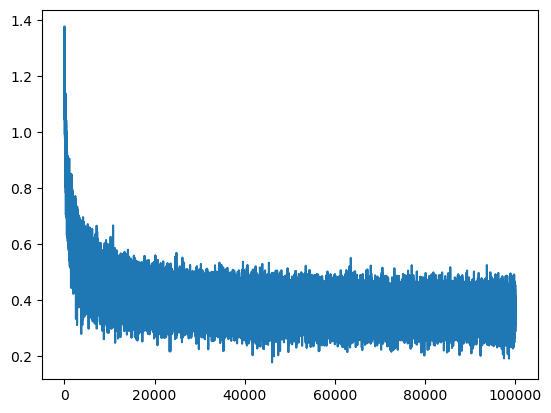

In [18]:
plt.plot(loss_i)
plt.show()

In [19]:
# Forward pass (valid dataset)
input_layer = F.one_hot(X_valid, num_classes=vocab).float()
embedd_layer = input_layer.view(-1, 81) @ C
hidden_layer = torch.tanh(embedd_layer @ W1 + b1)
output_layer = hidden_layer @ W2 + b2
loss = F.cross_entropy(output_layer, Y_valid)
loss

tensor(2.3975, grad_fn=<NllLossBackward0>)

In [24]:
out = []
context = [0] * block_size

while True:
    input_layer = F.one_hot(torch.tensor(context), num_classes=vocab).float()
    embedd_layer = input_layer.view(-1, 81) @ C
    hidden_layer = torch.tanh(embedd_layer @ W1 + b1)
    output_layer = hidden_layer @ W2 + b2
    probs = F.softmax(output_layer, dim=1)
    pred_idx = torch.multinomial(probs, num_samples=1, generator=g).item()

    context = context[1:] + [pred_idx]
    out.append(pred_idx)
    if pred_idx == 0:
        break

print("".join(itos[i] for i in out))

sedas.
